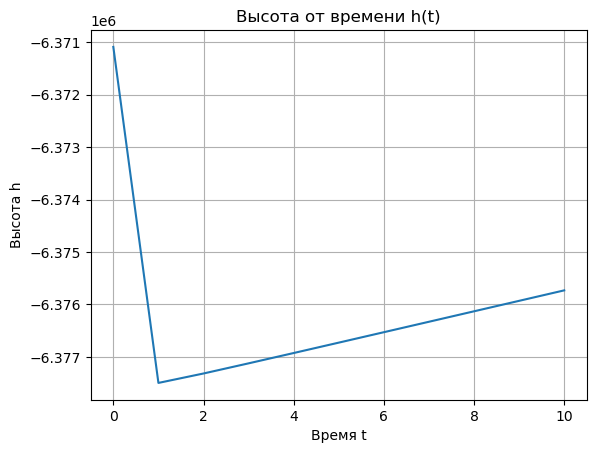

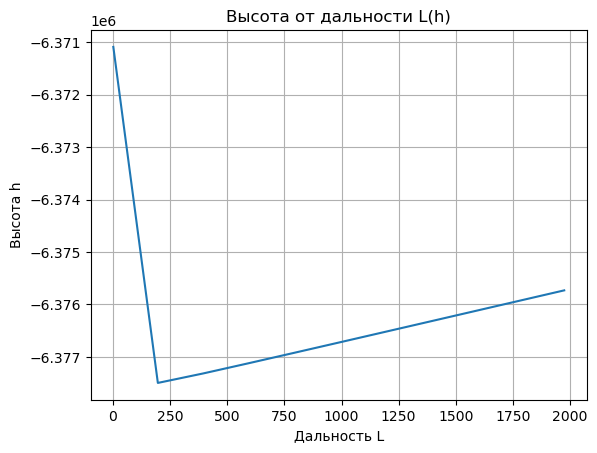

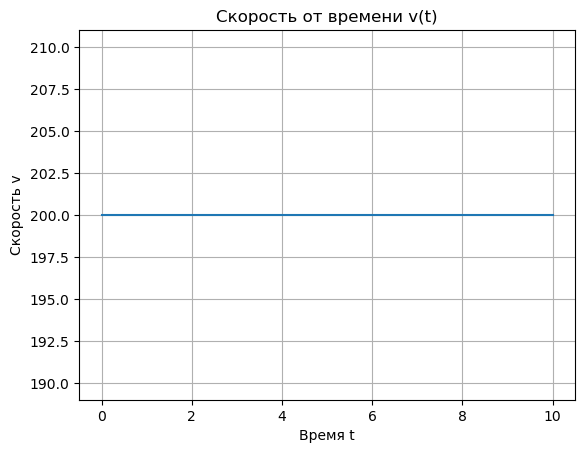

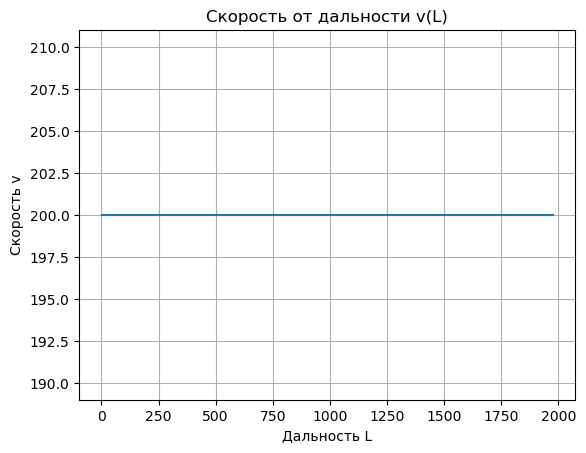

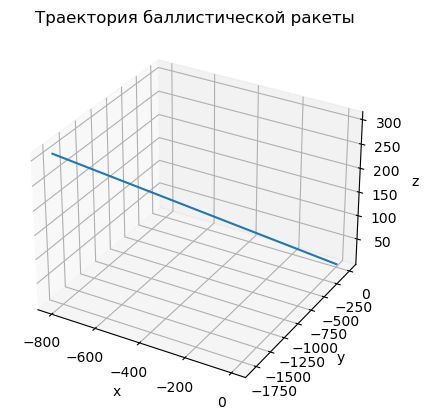

,t,x,y,z,h
0,0,1.000000,1.000000,1.00000,-6.371092e+06
1,1,-79.639596,-179.403756,31.85029,-6.377495e+06
2,2,-160.279193,-359.807512,62.70058,-6.377315e+06
3,3,-240.918789,-540.211267,93.55087,-6.377122e+06
4,4,-321.558386,-720.615023,124.40116,-6.376925e+06
5,5,-402.197982,-901.018779,155.25145,-6.376727e+06
6,6,-482.837579,-1081.422535,186.10174,-6.376528e+06
7,7,-563.477175,-1261.826290,216.95203,-6.376329e+06
8,8,-644.116772,-1442.230046,247.80232,-6.376130e+06
9,9,-724.756368,-1622.633802,278.65261,-6.375931e+06


In [57]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
# import math
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D
# -----------------------------------------------------------------------------------------------
# начальные значения
v0 = 200                                 # начальная скорость БЦ, м/с
theta = 30
phi = 20
# -----------------------------------------------------------------------------------------------
# константы
a = 6378245                             # большая полуось Земли
GM = 3.986004418e14                     # произведение гравитационной постоянной Земли на массу
c_0 = 2.202095e10                       # коэффициент гравитационного поля Земли
omega = 7.292115e-5                     # угловая скорость вращения Земли
f = 298.3                               # коэффициент сжатия Земли
e_squared = (2*f-1)/((f - 1)**2)        # квадрат эксцентриситета Земли
# -----------------------------------------------------------------------------------------------
def equations(t, state):
    x, y, z, vx, vy, vz = state
    # вычисление производных 
    dx_dt = vx
    dy_dt = vy
    dz_dt = vz
    # учет ускорения свободного падения g_0
    r_0 = np.sqrt(x**2 + y**2 + z**2)
    A = GM/r_0**3
    B = (3*c_0)/r_0**2
    C = (15*c_0)/r_0**4
    D = (6*c_0)/r_0**2
    
    dvx_dt = -A*x + A*B*x - A*C*x*z**2
    dvy_dt = -A*y + A*B*y - A*B*y*z**2
    dvz_dt = -A*z + A*B*z - D*z + C*z**3
    
    # учет центростремительного ускорения БЦ
    dvx_dt += omega**2 * x
    dvy_dt += omega**2 * y
    dvz_dt += 0
    
    # учет кориолисова ускорения
    dvx_dt += 2 * omega * dy_dt
    dvy_dt += -2 * omega * dx_dt
    dvz_dt += 0
    
    # учет аэродинамического ускорения 
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # тк в задании не даны начальная масса БЦ, и другие данные, чтобы посчитать баллистический коэффициент, я приму gamma = 0,347 (нашла значения для пули)
    gamma = 0.347 # для более точных расчетов нужно в процессе полета пересчитывать это значение (но тк начальных параметров нет, здесь я этого не делаю)
    s = z/r_0                                     # синус широты цели
    h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
    rho = 10**(-1.8977 * 10**-29 * h**6 + 8.7419 * 10**-24 * h**5 - 1.4909 * 10**-18 * h**4 + 1.1591 * 10**(-13) * h**3 - 4.0740 * 10**(-9) * h**2 - 8.0463 * 10**(-6) * h + 2.0667 * 10**(-2))
    E = (-gamma * rho * v)/2
    
    dvx_dt = E * dx_dt
    dvy_dt = E * dy_dt
    dvz_dt = E * dz_dt
    
    return np.array([dx_dt, dy_dt, dz_dt, dvx_dt, dvy_dt, dvz_dt])
# -------------------------------------------------------------------------------------
def runge_kutta_4(t0, t_end, dt, initial_state):
    t = t0
    states = [initial_state]
    
    while t < t_end:
        state = states[-1]
        k1 = dt * equations(t, state)
        k2 = dt * equations(t + dt/2, state + k1/2)
        k3 = dt * equations(t + dt/2, state + k2/2)
        k4 = dt * equations(t + dt, state + k3)
        
        new_state = state + (k1 + 2*k2 + 2*k3 + k4)/6           # state = | x | y | z | vx | vy | vz |
        states.append(new_state)                                # coordinates + speeds
        
        t += dt
    
    return np.array(states)
# -------------------------------------------------------------------------------------
def main():
    t0 = 0
    t_end = 10
    dt = 1
    initial_state = np.array([1, 1, 1, v0 * np.sin(theta) * np.cos(phi), v0 * np.sin(theta) * np.sin(phi), v0 * np.cos(theta)])
    result = runge_kutta_4(t0, t_end, dt, initial_state)

    # извлечение координат и времени из результата
    x = result[:, 0]
    y = result[:, 1]
    z = result[:, 2]
    vx = result[:, 3]
    vy = result[:, 4]
    vz = result[:, 5]
    t = np.arange(t0, t_end + dt, dt)
    t_list = t.tolist()
    
    return [x, y, z, vx, vy, vz, t_list] 
# -------------------------------------------------------------------------------------
result = main()
result_data = pd.DataFrame()
result_data['t'] = result[6]
result_data['x'] = result[0]
result_data['y'] = result[1]
result_data['z'] = result[2]
# -------------------------------------------------------------------------------------
# вычисление высоты, скорости и ускорения
x = result[0]
y = result[1]
z = result[2]
vx = result[3]
vy = result[4]
vz = result[5]
t = result[6]

v = np.sqrt(vx**2 + vy**2 + vz**2)
r_0 = np.sqrt(x**2 + y**2 + z**2)
s = z/r_0                                     # синус широты цели
h = r_0 - a/(np.sqrt(1 + e_squared * s**2))   # высота БЦ над поверхностью Земли
result_data['h'] = h
# g = np.sqrt()
L = np.sqrt(x**2 + y**2)
# -------------------------------------------------------------------------------------
# Визуализация высоты от времени
plt.figure()
plt.plot(t, h)
plt.xlabel('Время t')
plt.ylabel('Высота h')
plt.title('Высота от времени h(t)')
plt.grid(True)

# Визуализация высоты от дальности
plt.figure()
plt.plot(L, h)
plt.xlabel('Дальность L')
plt.ylabel('Высота h')
plt.title('Высота от дальности L(h)')
plt.grid(True)

# Визуализация скорости от времени
plt.figure()
plt.plot(t, v)
plt.xlabel('Время t')
plt.ylabel('Скорость v')
plt.title('Скорость от времени v(t)')
plt.grid(True)

# Визуализация скорости от дальности
plt.figure()
plt.plot(L, v)
plt.xlabel('Дальность L')
plt.ylabel('Скорость v')
plt.title('Скорость от дальности v(L)')
plt.grid(True)

# # Визуализация ускорения от времени
# plt.figure()
# plt.plot(t, a)
# plt.xlabel('Время')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от времени')
# plt.grid(True)

# # Визуализация ускорения от дальности
# plt.figure()
# plt.plot(x, a)
# plt.xlabel('Дальность')
# plt.ylabel('Ускорение')
# plt.title('Ускорение от дальности')
# plt.grid(True)

# Визуализация траектории ракеты в 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория баллистической ракеты')

plt.show()
result_data
    